# Run passive model TOY model


In [1]:
import custommodel as ctm
import deterministicfunc as dgi 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


# Select model and input conductance to run

In [2]:
# List of models to tests: control, increased input resistance, etc
list_models= ['ctr','rin','depo','fr']

# Artificial spike threshold
APthreshold = -40

# Setup the list of multiplicators for input conductance - g = p x rheo_input
list_input0 = np.array(list(np.arange(0, 101, 5)/100))
print(len(list_input0))



21


In [3]:
print(list_input0[:5])
print(list_input0[-5:])

[0.   0.05 0.1  0.15 0.2 ]
[0.8  0.85 0.9  0.95 1.  ]


### Groups and parameters for the synaptic input

In [4]:
gl_drop = 0.79

modeldata = {'ctr':{'key_group':'ctr', 'gldrop': 1, 'clamprest': None}, 
             'fr':{'key_group':'fd', 'gldrop': gl_drop, 'clamprest': None}, 
             'rin':{'key_group':'ctr', 'gldrop': gl_drop, 'clamprest': None},
             'depo':{'key_group':'fd', 'gldrop': 1, 'clamprest': None}}


In [5]:
palette = {'ctr':(0.4,0.4,0.4), 
           'fr': (1,0,0),
           'rin': (1,0,0.5), 
           'depo': (0.5,0,1)}    
legend_mod = {'ctr':'control', 
           'fr': 'food restricted',
           'rin': 'increased input R', 
           'depo': 'depolarized membrane resting mV'}    

### Setup stimulus

In [6]:
stimdelay = 0
stimduration = 225 
intype = 'gsyn' # options: gsyn = conductance ; isyn = current synaptic input 

synparams = {'tau_rise':70, 'tau_decay':75,'Er':0, 'stimdelay':stimdelay, 'delay':0}  
# note: 'delay' is an additional delay - see where insert synapse
    
stim_params = ctm.get_simginputparameters(stimdelay, stimduration, intype, synparams=synparams)

# Get rheo

In [7]:
isstochastic = False

if intype=='gsyn':
    precision = 1e-3
    offInput = 10
    onInput = 150
else:
    precision = 1e-6
    offInput = 0.1
    onInput = 10

gfirstspike_models = {}
model_params_models = {}

for model in list_models:
    
    print("*** "+model+" ***")
    
    model_params = ctm.ModelParameters(modeldata[model]['key_group'], isstochastic, 
                                       modeldata[model]['gldrop'], APthreshold)
    
    dgi.check_setup_model_sim(model_params, stim_params)
    
    gfirstspike, _, is_success = dgi.get_firstspike_ginput(model_params,
                                                           stim_params,
                                                           offInput,
                                                           onInput,
                                                           precision)

    print(is_success)
    print(gfirstspike)
    
    gfirstspike_models[model] = gfirstspike
    
    # Save model
    model_params_models[model] = model_params

*** ctr ***
------------------------
Display model check...
	**Passive Model**
	-Resting potential and init E0 -75.0000 mV
	-Leak reversal potential -75.0000 mV
	-Leak conductance 0.1000 mS/cm2
	-Capa 1.0000 uF/cm2
	-Total duration of stimulation 225.00 ms
	-Total duration of simulation 225.00 ms
	-Syn noise for trial variability 0.000 (sd)
True
87.771
*** rin ***
------------------------
Display model check...
	**Passive Model**
	-Resting potential and init E0 -75.0000 mV
	-Leak reversal potential -75.0000 mV
	-Leak conductance 0.0790 mS/cm2
	-Capa 1.0000 uF/cm2
	-Total duration of stimulation 225.00 ms
	-Total duration of simulation 225.00 ms
	-Syn noise for trial variability 0.000 (sd)
True
69.4871
*** depo ***
------------------------
Display model check...
	**Passive Model**
	-Resting potential and init E0 -70.0000 mV
	-Leak reversal potential -70.0000 mV
	-Leak conductance 0.1000 mS/cm2
	-Capa 1.0000 uF/cm2
	-Total duration of stimulation 225.00 ms
	-Total duration of simulation 

### Get compensation

In [8]:
ref_model = 'ctr'

rcomp_models = {}

for model in list_models:
    
    print("*** "+model+" ***")
    
    rcomp_models[model] = gfirstspike_models[model] / gfirstspike_models[ref_model]
    

    print(rcomp_models[model])
    
 

*** ctr ***
1.0
*** rin ***
0.791686320082943
*** depo ***
0.8575645714415924
*** fr ***
0.6791673787469665


# Run various input to get I/O curve

In [9]:
rec_var_models = {}

for model in list_models:
    
    print("*** "+model+" ***")

    # Setup the input
    list_input = list(rcomp_models[model]*gfirstspike_models[ref_model]*list_input0)
    
    rec_var_models[model] = dgi.run_io_ginput(model_params_models[model], stim_params, 
                                              list_input, 1)
    


*** ctr ***
*** rin ***
*** depo ***
*** fr ***


### Fractional response

In [10]:
fresp_models = {}

for model, rec_var in rec_var_models.items():

    response = [v_list[0]-model_params_models[model].E0 for v_list in rec_var_models[model]['vmax']]
    fresp_models[model] = [r/(APthreshold-model_params_models[model].E0) for r in response]
 

### Plot 

(-0.01, 1.01)

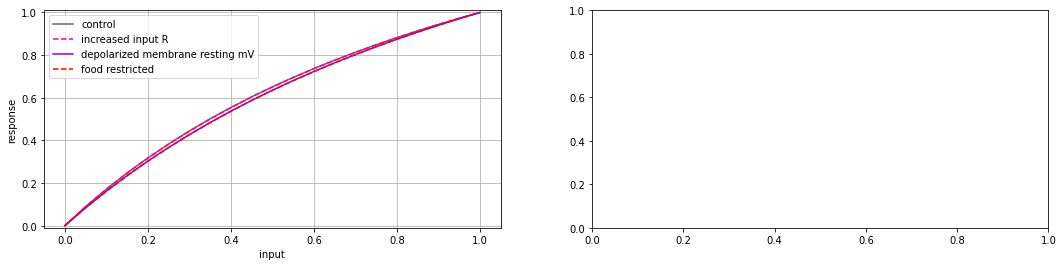

In [13]:
ylim = [-0.01,1.01]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4))

idx = 0
for model, y in fresp_models.items():

    if model == 'ctr' or model == 'depo':
        ls = '-'
    else:
        ls = '--'
    ax[idx].plot(list_input0, y, ls,color=palette[model], label=legend_mod[model])
    
ax[idx].set_xlabel('input')
ax[idx].set_ylabel('response')
ax[idx].grid()
ax[idx].legend()
ax[idx].set_ylim(ylim)

"""
NOTE: the tiny bias observed in fractional response disappears with current injection.
With input conductance this bias is due to the the synaptic driving force when depolarize from rest.
""";